## Notebook 1: Regression of energy consumption in building design

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from tensorflow import keras
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from pickle import dump

D:\Software\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [3]:
# Calculate total energy consumption by summing up heating and cooling loads
data['Energy Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

(768, 11)


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

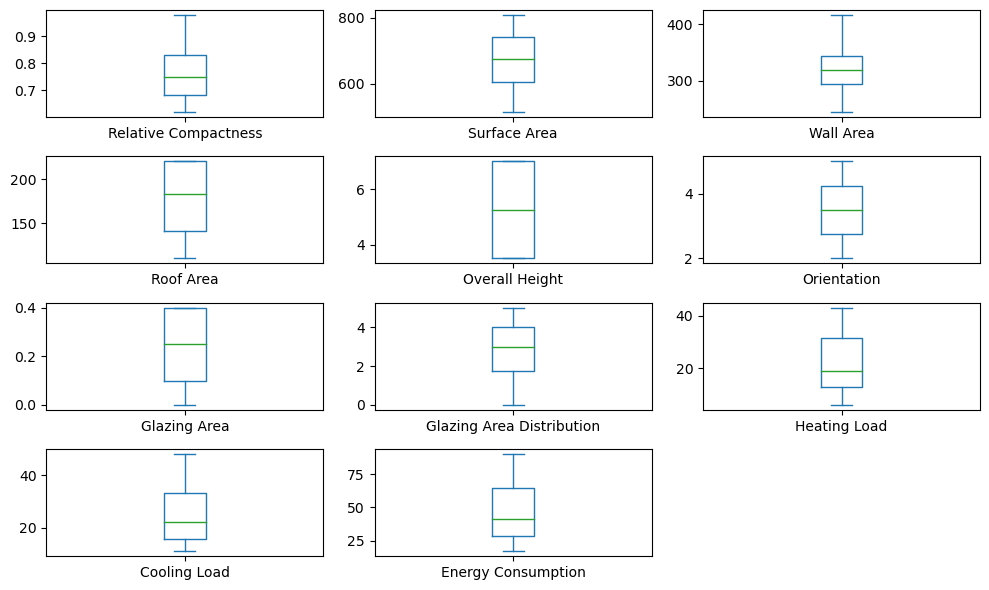

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

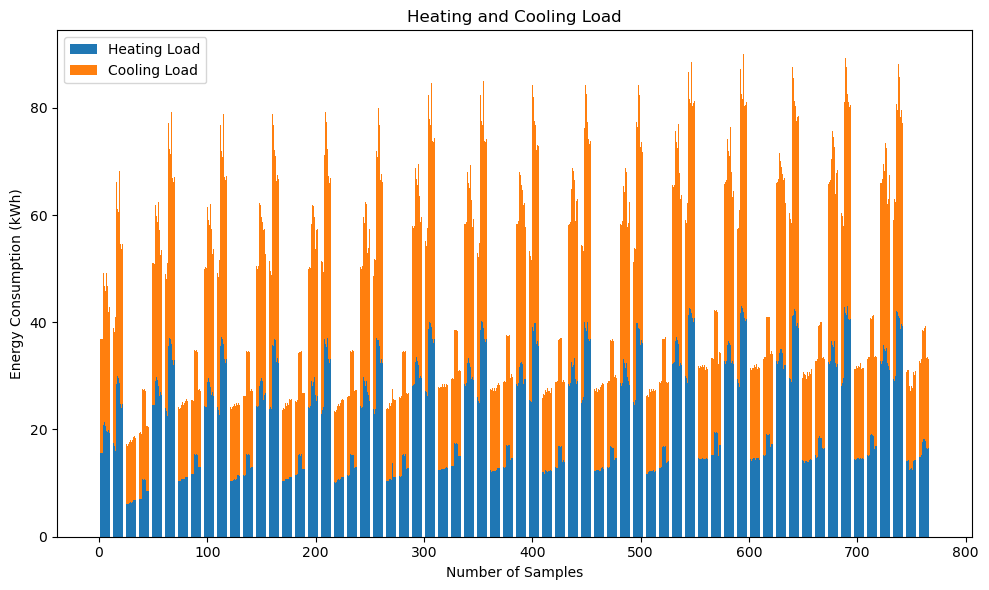

In [7]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

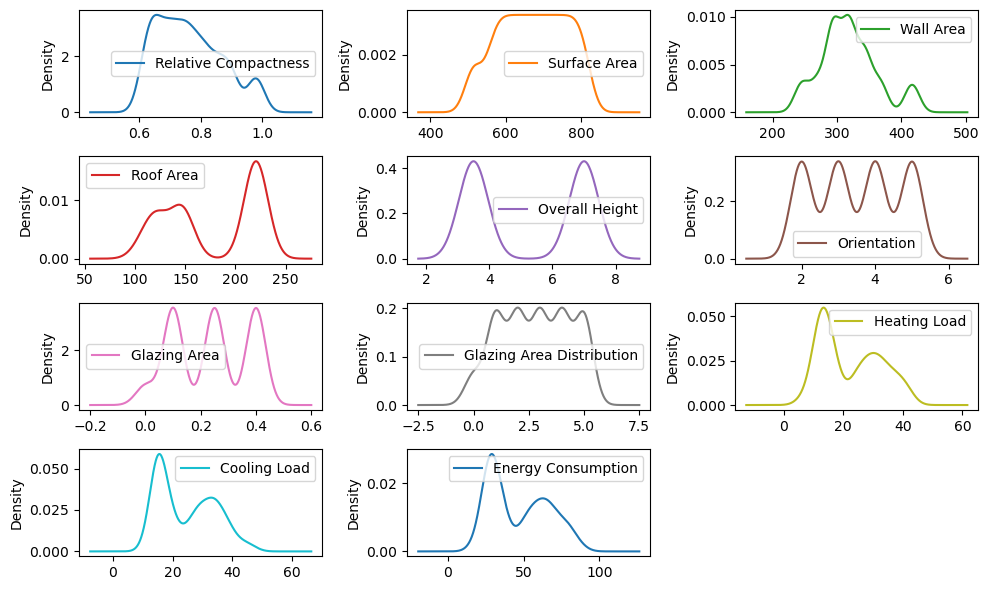

In [8]:
# Create density plots to check the Gaussian distribution of features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

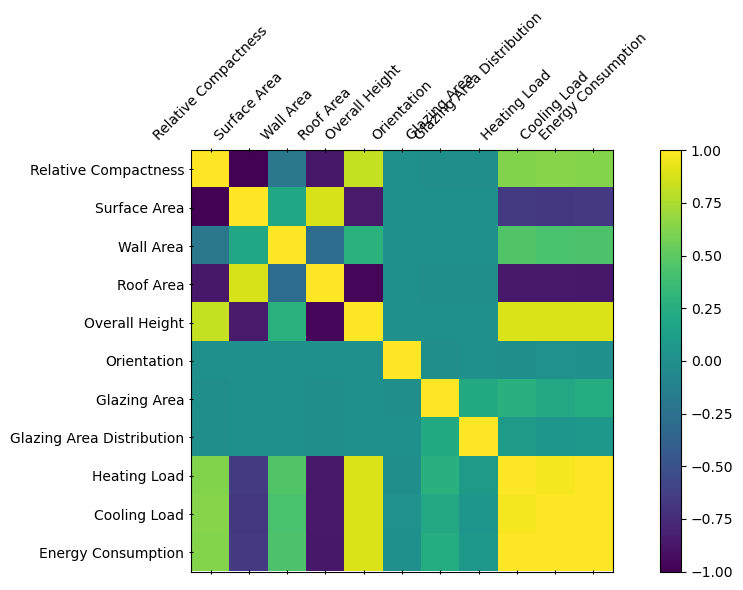

In [9]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

The correlation matrix indicates heating and coolind loads and energy consumption are strongly correlated to overall height. 

**3. Prepare Data**

In [10]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy Consumption           700
dtype: int64


In [11]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy Consumption           0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [12]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy Consumption']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [13]:
# b) Split-out dataset into train, test, and validation sets

train = data[:int(len(data) * 0.7)]
test = data[int(len(data) * 0.7):int(len(data) * 0.9)]
validation = data[int(len(data) * 0.9):]
print(train.shape, test.shape, validation.shape)

X_train = train.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
X_test = test.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
X_val = validation.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y_train = train['Energy Consumption']
y_test = test['Energy Consumption']
y_val = validation['Energy Consumption']

(537, 11) (154, 11) (77, 11)


In [14]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)
X_val = DataFrame(X_val)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(537, 8) (154, 8) (77, 8)
(537,) (154,) (77,)


**4. Evaluate Algorithms**

In [15]:
# a) Spot check algorithms
# ML: Linear Regression
results = []
names = []

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)
LR = model_LR.score(X_test, y_test)
results.append(LR)
names.append('LR')

In [16]:
# Define baseline mean_absolute_error of y_test in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_test))
mae_ori = mean_absolute_error(y_test, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

# Calculate mean_absolute_error of the prediction
mae_pred_LR = mean_absolute_error(y_test, y_pred_LR)
print("Mean Absolute Error of predicted data: ", mae_pred_LR)

Mean Absolute Error of original data:  19.058703835227274
Mean Absolute Error of predicted data:  14.657582333544719


In [17]:
# Ensemble: Random Forest algorithm
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)
RF = model_RF.score(X_test, y_test)
results.append(RF)
names.append('RF')

In [18]:
# Calculate mean_absolute_error of the prediction
mae_pred_RF = mean_absolute_error(y_test, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  15.093064935064934


In [19]:
# Ensemble: XGBoost algorithm
# Use DMatrix to convert input data into internal data structure that is optimized for both memory efficiency and training speed.

df_xgb = xgb.DMatrix(data=X, label=y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.1, random_state=42)

model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)

model_xgb.fit(X_train2,y_train2)

# Prediction
y_pred_XG = model_xgb.predict(X_test2)
XGB = model_xgb.score(X_test2, y_test2)
results.append(XGB)
names.append('XGB')

D:\Software\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [20]:
# Calculate mean_absolute_error of the prediction
mae_pred_XG = mean_absolute_error(y_test2, y_pred_XG)
print("Mean Absolute Error of predicted data: ", mae_pred_XG)

Mean Absolute Error of predicted data:  1.2561789842085402


In [21]:
# Compare algorithms
print(names, results)

['LR', 'RF', 'XGB'] [0.3682149626139699, 0.35072647289298975, 0.9922331617857651]


The complex distribution of input variables  has led to lower-than-anticipated  scores and mean absolute error (MAE) of both Linear Regression and Random Forest models compared to those of XGBoost.

In [22]:
# b) Neural Network algorithms
# create keras Sequential model with 3 layers
NN_model = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (8, ), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)  
])

NN_model.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

In [23]:
# Define a callback for early stopping if the validation loss does not improve for 20 consecutive 
# epochs (patience=20).
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

Epoch 1/500
5/5 [==============================] - 3s 261ms/step - loss: 11.1115 - mse: 2419.2385 - val_loss: 14.5560 - val_mse: 3252.8748
Epoch 2/500
5/5 [==============================] - 0s 34ms/step - loss: 9.8253 - mse: 2514.9597 - val_loss: 14.1359 - val_mse: 3249.1233
Epoch 3/500
5/5 [==============================] - 0s 34ms/step - loss: 9.2189 - mse: 2551.5869 - val_loss: 13.7885 - val_mse: 3243.7805
Epoch 4/500
5/5 [==============================] - 0s 32ms/step - loss: 8.8026 - mse: 2564.2002 - val_loss: 13.4367 - val_mse: 3235.5703
Epoch 5/500
5/5 [==============================] - 0s 34ms/step - loss: 8.5511 - mse: 2565.4299 - val_loss: 13.0248 - val_mse: 3224.1016
Epoch 6/500
5/5 [==============================] - 0s 33ms/step - loss: 8.1523 - mse: 2548.3655 - val_loss: 12.5048 - val_mse: 3207.9883
Epoch 7/500
5/5 [==============================] - 0s 33ms/step - loss: 7.8720 - mse: 2505.7698 - val_loss: 12.0526 - val_mse: 3193.9285
Epoch 8/500
5/5 [======================

Epoch 61/500
5/5 [==============================] - 0s 33ms/step - loss: 2.5273 - mse: 2144.7341 - val_loss: 2.5272 - val_mse: 2278.2739
Epoch 62/500
5/5 [==============================] - 0s 34ms/step - loss: 2.4723 - mse: 2140.6089 - val_loss: 2.4871 - val_mse: 2263.5203
Epoch 63/500
5/5 [==============================] - 0s 29ms/step - loss: 2.4366 - mse: 2162.4666 - val_loss: 2.4473 - val_mse: 2248.2468
Epoch 64/500
5/5 [==============================] - 0s 31ms/step - loss: 2.3920 - mse: 2081.4333 - val_loss: 2.4068 - val_mse: 2231.3293
Epoch 65/500
5/5 [==============================] - 0s 40ms/step - loss: 2.3179 - mse: 2083.2842 - val_loss: 2.3725 - val_mse: 2217.1829
Epoch 66/500
5/5 [==============================] - 0s 33ms/step - loss: 2.2852 - mse: 2066.8940 - val_loss: 2.3431 - val_mse: 2203.6328
Epoch 67/500
5/5 [==============================] - 0s 32ms/step - loss: 2.1958 - mse: 2001.2209 - val_loss: 2.3132 - val_mse: 2190.7495
Epoch 68/500
5/5 [=======================

5/5 [==============================] - 0s 29ms/step - loss: 0.7381 - mse: 1228.3909 - val_loss: 0.8207 - val_mse: 1331.7899
Epoch 121/500
5/5 [==============================] - 0s 31ms/step - loss: 0.7356 - mse: 1141.6356 - val_loss: 0.8019 - val_mse: 1312.7035
Epoch 122/500
5/5 [==============================] - 0s 31ms/step - loss: 0.6891 - mse: 1105.5117 - val_loss: 0.7915 - val_mse: 1304.4504
Epoch 123/500
5/5 [==============================] - 0s 31ms/step - loss: 0.7479 - mse: 1083.5621 - val_loss: 0.7832 - val_mse: 1300.0983
Epoch 124/500
5/5 [==============================] - 0s 30ms/step - loss: 0.6997 - mse: 1015.1926 - val_loss: 0.7770 - val_mse: 1298.3260
Epoch 125/500
5/5 [==============================] - 0s 33ms/step - loss: 0.7364 - mse: 952.5370 - val_loss: 0.7666 - val_mse: 1290.1349
Epoch 126/500
5/5 [==============================] - 0s 32ms/step - loss: 0.6777 - mse: 1001.3685 - val_loss: 0.7554 - val_mse: 1281.6464
Epoch 127/500
5/5 [==============================

Epoch 180/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2353 - mse: 428.4435 - val_loss: 0.3971 - val_mse: 826.0509
Epoch 181/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2315 - mse: 428.9764 - val_loss: 0.3938 - val_mse: 824.9231
Epoch 182/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2306 - mse: 408.3594 - val_loss: 0.3854 - val_mse: 819.7039
Epoch 183/500
5/5 [==============================] - 0s 30ms/step - loss: 0.2041 - mse: 408.1807 - val_loss: 0.3801 - val_mse: 816.2169
Epoch 184/500
5/5 [==============================] - 0s 30ms/step - loss: 0.2234 - mse: 405.9540 - val_loss: 0.3742 - val_mse: 810.7946
Epoch 185/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2210 - mse: 409.7861 - val_loss: 0.3711 - val_mse: 806.0519
Epoch 186/500
5/5 [==============================] - 0s 30ms/step - loss: 0.2209 - mse: 393.0384 - val_loss: 0.3682 - val_mse: 799.6583
Epoch 187/500
5/5 [=============================

5/5 [==============================] - 0s 31ms/step - loss: 0.0739 - mse: 185.9357 - val_loss: 0.2715 - val_mse: 585.9467
Epoch 241/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0728 - mse: 177.4903 - val_loss: 0.2702 - val_mse: 581.9567
Epoch 242/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0682 - mse: 169.6022 - val_loss: 0.2693 - val_mse: 579.6062
Epoch 243/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0651 - mse: 164.8984 - val_loss: 0.2678 - val_mse: 576.5518
Epoch 244/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0685 - mse: 168.8514 - val_loss: 0.2662 - val_mse: 573.4873
Epoch 245/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0636 - mse: 161.8423 - val_loss: 0.2637 - val_mse: 568.6699
Epoch 246/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0647 - mse: 159.8364 - val_loss: 0.2617 - val_mse: 565.1593
Epoch 247/500
5/5 [==============================] - 0s 31ms/s

5/5 [==============================] - 0s 33ms/step - loss: 0.0317 - mse: 81.0291 - val_loss: 0.1956 - val_mse: 425.5026
Epoch 301/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0393 - mse: 94.1995 - val_loss: 0.1946 - val_mse: 424.2154
Epoch 302/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0329 - mse: 87.8167 - val_loss: 0.1945 - val_mse: 424.4381
Epoch 303/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0374 - mse: 90.0105 - val_loss: 0.1927 - val_mse: 422.8135
Epoch 304/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0334 - mse: 83.0292 - val_loss: 0.1898 - val_mse: 422.2256
Epoch 305/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0342 - mse: 87.1016 - val_loss: 0.1873 - val_mse: 421.3842
Epoch 306/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0334 - mse: 84.4651 - val_loss: 0.1866 - val_mse: 420.7975
Epoch 307/500
5/5 [==============================] - 0s 33ms/step - l

Epoch 361/500
5/5 [==============================] - 0s 28ms/step - loss: 0.0255 - mse: 63.3238 - val_loss: 0.1650 - val_mse: 363.0411
Epoch 362/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0244 - mse: 59.8991 - val_loss: 0.1654 - val_mse: 360.8600
Epoch 363/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0238 - mse: 61.0920 - val_loss: 0.1653 - val_mse: 358.0588
Epoch 364/500
5/5 [==============================] - 0s 27ms/step - loss: 0.0250 - mse: 57.5602 - val_loss: 0.1653 - val_mse: 355.3005
Epoch 365/500
5/5 [==============================] - 0s 28ms/step - loss: 0.0275 - mse: 65.1137 - val_loss: 0.1648 - val_mse: 352.1633
Epoch 366/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0241 - mse: 59.5869 - val_loss: 0.1637 - val_mse: 348.7510
Epoch 367/500
5/5 [==============================] - 0s 29ms/step - loss: 0.0276 - mse: 67.3901 - val_loss: 0.1644 - val_mse: 349.1015
Epoch 368/500
5/5 [==============================] - 0s

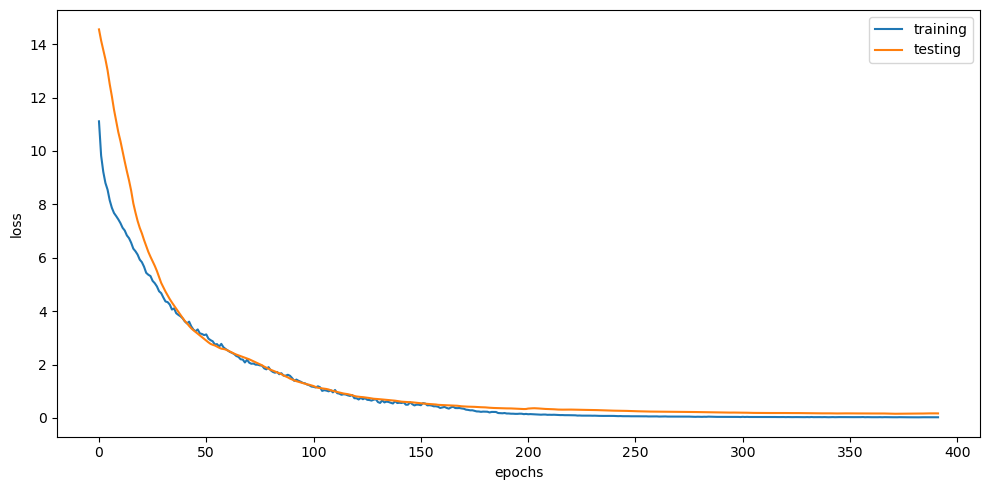

In [24]:
# fit the keras model on the dataset
model_fit = NN_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=500, batch_size=128, callbacks=[early_stopping])

# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_fit.history['loss'], label = 'training')
plt.plot(model_fit.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

The loss values of the training (0.02) and validation (0.17) indicate a relatively acceptable level of accuracy in predicting the actual values.

In [25]:
# Prediction
y_pred_NN = NN_model.predict(X_val)

# Calculate mean_absolute_error of the prediction
mae_pred_NN = mean_absolute_error(y_val, y_pred_NN)
print("Mean Absolute Error of predicted data: ", mae_pred_NN)

3/3 [==============================] - 0s 4ms/step
Mean Absolute Error of predicted data:  15.096375733412707


Of the three ML algorithms and the neural network model, XGBoost demonstrated superior performance in terms of MAE values and was chosen as the optimal model.

**5. Finalize Model**

In [26]:
# a) Predictions on validation dataset
# XGBoost algorithm estimate accuracy on validation dataset
y_pred_xgb = model_xgb.predict(X_val2)

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. The resulting mean absolute error indicates that the prediction performance of the Keras Sequential neural network is similar to that of the Linear Regression model.

In [27]:
# Calculate mean_absolute_error of the prediction
mae_pred_xgb = mean_absolute_error(y_val2, y_pred_xgb)
print("Mean Absolute Error of predicted data: ", mae_pred_XG)

Mean Absolute Error of predicted data:  1.2561789842085402


In [28]:
# Get the model's parameters
model_params = model_xgb.get_params()

# Print the model's parameters
print(model_params)

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.3, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 10, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 10, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'alpha': 10}


In [29]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_xgb, open(filename, 'wb'))

**6. Conclusions**

- Exploratory data analysis shows that the input variables are almost non-Gaussian distribution.

- Out of the three machine learning algorithms, XGBoost achieved a much higher score of 0.99 compared to Linear Regression and Random Forest, which scored in the range 0.36 to 0.45.

- Consistent MAE values in test and validation prove that there's not overfitting in XGBoost performance evaluation.

- The performance of the neural network model (Keras Sequential) with 3 layers and dropput regulation and BatchNormalization is comparable to Linear Regression and Random Forest algorithms. Further tunning of the hyperparameter may yield a better prediction score.